In [1]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten

from keras.models import Sequential

import numpy as np
from sklearn.metrics import roc_curve, auc, average_precision_score

from helper import IOHelper, SequenceHelper

Using Theano backend.


Load the sequence data:

In [2]:
input_real = IOHelper.get_fastas_from_file("data/pu1.fa.gz", uppercase=True)
sequence_length = len(input_real.sequence[0])
X_real = SequenceHelper.do_one_hot_encoding(input_real.sequence, sequence_length,
                                            SequenceHelper.parse_alpha_to_seq)

In [3]:
def do_dinucleotide_shuffling(X, size=1):
    x_shuffled = np.repeat(X, size, 0)

    for x in range(0, x_shuffled.shape[0]):
        random_index = np.arange(0, int(X.shape[1]/2))
        np.random.shuffle(random_index)
        for y in range(0, int(X.shape[1]/2)):
            x_shuffled[x,y*2, ] = X[int(x%X.shape[0]),random_index[y]*2]
            x_shuffled[x,(y*2)+1, ] = X[int(x%X.shape[0]),(random_index[y]*2)+1]

    return x_shuffled

seq_shuffled = do_dinucleotide_shuffling(np.array([[[e] for e in list(x)] for x in input_real.sequence]), size=1)
seq_shuffled = np.array(["".join(seq_shuffled[x, :, 0]) for x in range(seq_shuffled.shape[0])])
X_shuffled = SequenceHelper.do_one_hot_encoding(seq_shuffled, sequence_length,
                                                SequenceHelper.parse_alpha_to_seq)

Create the Neurol Network Architecture

In [5]:

model = Sequential()
model.add(Conv2D(16, (12, 4), padding='valid', input_shape=(100, 4, 1),
                        activation='relu'))

model.add(MaxPooling2D(pool_size=(15,1), padding='valid'))

model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 89, 1, 16)         784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 1, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2592      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,409.0
Trainable params: 3,409.0
Non-trainable params: 0.0
_________________________________________________________________


Create a test and a training subset

In [6]:
shuffling = np.arange(X_real.shape[0] + X_shuffled.shape[0])
np.random.shuffle(shuffling)

X = np.concatenate((X_real, X_shuffled))[shuffling, :, :]
X = np.nan_to_num(X)
Y = np.concatenate((np.ones(X_real.shape[0]), np.zeros(X_shuffled.shape[0])))[shuffling]


X_train = X[0:int(X.shape[0]*0.8), :, :]
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
Y_train = Y[0:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):X.shape[0], :, :]
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
Y_test = Y[int(X.shape[0]*0.8):X.shape[0]]

In [7]:
print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(45883, 100, 4, 1)
(11471, 100, 4, 1)


## Fit the Model

In [8]:
model.fit(X_train_reshaped, Y_train,
          batch_size=10, epochs=25,
          validation_data=(X_test_reshaped, Y_test))


Train on 45883 samples, validate on 11471 samples
Epoch 1/25
45883/45883 [==============================] - 6s - loss: 0.2394 - val_loss: 0.2061
Epoch 2/25
45883/45883 [==============================] - 6s - loss: 0.1398 - val_loss: 0.1098
Epoch 3/25
45883/45883 [==============================] - 5s - loss: 0.0995 - val_loss: 0.0954
Epoch 4/25
45883/45883 [==============================] - 5s - loss: 0.0829 - val_loss: 0.0764
Epoch 5/25
45883/45883 [==============================] - 5s - loss: 0.0682 - val_loss: 0.0639
Epoch 6/25
45883/45883 [==============================] - 6s - loss: 0.0587 - val_loss: 0.0593
Epoch 7/25
45883/45883 [==============================] - 7s - loss: 0.0532 - val_loss: 0.0533
Epoch 8/25
45883/45883 [==============================] - 6s - loss: 0.0498 - val_loss: 0.0517
Epoch 9/25
45883/45883 [==============================] - 6s - loss: 0.0473 - val_loss: 0.0483
Epoch 10/25
45883/45883 [==============================] - 6s - loss: 0.0456 - val_loss: 0.0476

### Evaluate the Model

In [9]:
pred = model.predict(X_test_reshaped, batch_size=32).flatten()
fpr, tpr, thresholds = roc_curve(Y_test, pred)
print("AUC", auc(fpr, tpr))
print("AUPRC", average_precision_score(Y_test, pred))

('AUC', 0.98426109273336071)
('AUPRC', 0.98349633501660028)


In [10]:
pred

array([ 0.00357287,  0.97478938,  0.99676901, ...,  0.83104032,
        0.9923467 ,  0.99998659], dtype=float32)

## Extract the training weights to make a motif plot:

In [16]:
score_sequences = range(0, 5)

X_For_Scoring = X_real.reshape((X_real.shape[0], X_real.shape[1], X_real.shape[2], 1))[score_sequences, :]
Pred_For_Scoring = model.predict(X_For_Scoring, batch_size=32).flatten()
tmp = np.repeat(X_For_Scoring, 100, axis=0)

(5, 100, 4, 1)
(500, 100, 4, 1)


Calculate Gradient

In [17]:
a = np.ones((100, 100), int)
np.fill_diagonal(a, 0)
b = np.repeat(a.reshape((1,100,100)), X_For_Scoring.shape[0], axis=0)
c = np.concatenate(b, axis=0)
d = np.multiply(tmp, np.repeat(c.reshape((tmp.shape[0], 100, 1, 1)), 4, axis=2))

In [24]:
new_pred = model.predict(d, batch_size=32).flatten()
scores = np.reshape((np.repeat(Pred_For_Scoring, 100) - new_pred), (len(score_sequences),100))
# scores = np.reshape((1-new_pred)/(1-np.repeat(Pred_For_Scoring, 100))-1, (len(score_sequences),100))

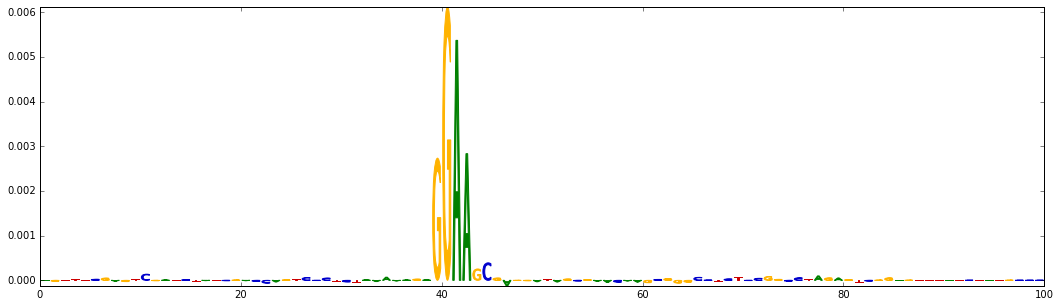

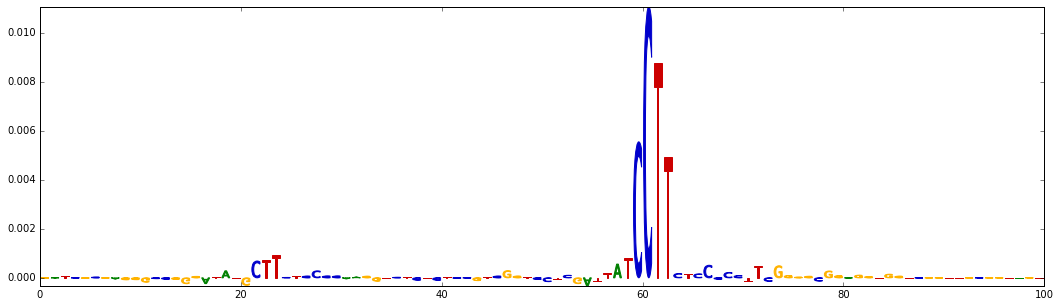

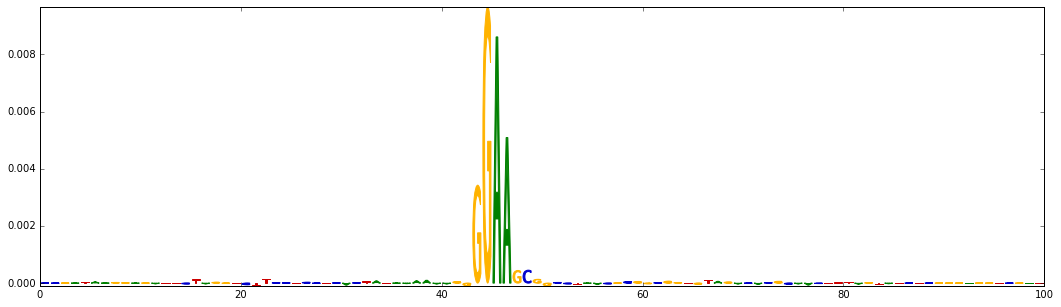

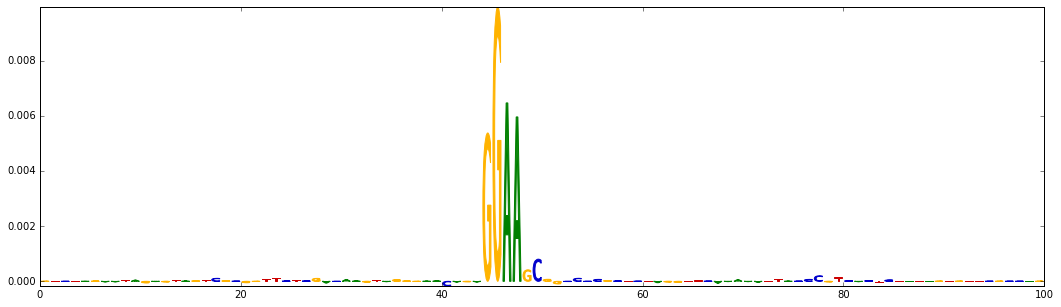

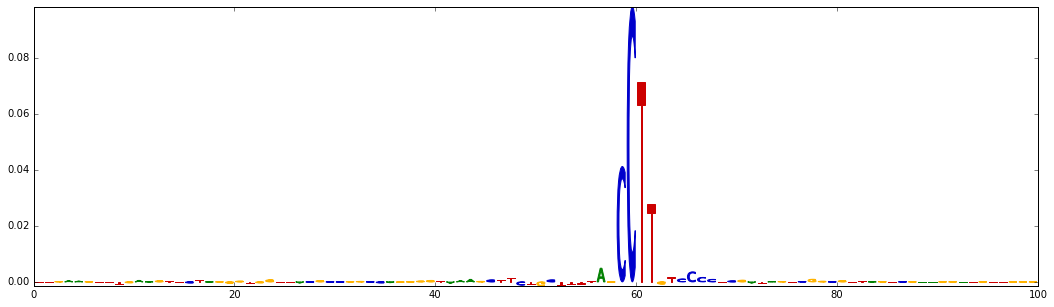

In [25]:
%matplotlib inline

import motif_plotter
import matplotlib.pyplot as plt

for plot_index in range(0,len(score_sequences)):
    fig=plt.figure(figsize=(18, 5), dpi= 80)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax, X_For_Scoring[plot_index].reshape((100, 4)),
                                                np.arcsinh(scores[plot_index]).reshape(100,1))
    plt.show()
